In [17]:
import numpy as np
import pandas as pd
import random

# Reproducibility
np.random.seed(42)
random.seed(42)

def generate_synthetic_data(n_samples=5000, fraud_heavy=False):

    fraud_templates = [
        "Multiple linked accounts with coordinated dispute behavior.",
        "High dispute velocity within short time window.",
        "Pattern matches prior confirmed abuse cluster.",
        "Chargeback ratio exceeds acceptable threshold.",
        "Recurring fraud indicators aligned with historical abuse patterns.",
        "Risky order pattern detected.",
        "Bad GSI associated with prior abuse.",
        "Card velocity anomaly detected."
    ]

    weak_templates = [
        "Single dispute reported by customer.",
        "No prior history of abuse.",
        "Long-standing account with stable behavior.",
        "Insufficient evidence for coordinated fraud.",
        "Customer claims non-delivery without supporting signals.",
        "Address formatting irregular but no abuse pattern.",
        "Multiple pending orders but no coordinated fraud."
    ]

    data = []

    for _ in range(n_samples):

        # Fraud score distribution
        if fraud_heavy:
            fraud_score = np.random.beta(5, 2)
        else:
            fraud_score = np.random.beta(2, 5)

        prior_disputes = np.random.poisson(2)
        total_dispute_amount = np.random.gamma(2, 150)
        account_age_days = np.random.exponential(365)
        linked_accounts_count = np.random.poisson(1)
        investigator_tenure_months = np.random.exponential(24)

        # Annotation selection with controlled noise
        if fraud_score > 0.6:
            annotation_text = random.choices(
                [random.choice(fraud_templates), random.choice(weak_templates)],
                weights=[0.85, 0.15]
            )[0]
        else:
            annotation_text = random.choices(
                [random.choice(weak_templates), random.choice(fraud_templates)],
                weights=[0.85, 0.15]
            )[0]

        # Text signal extraction
        text_signal = 1 if any(keyword in annotation_text.lower() for keyword in
                                ["linked", "velocity", "cluster", "abuse", "risky", "bad gsi"]) else 0

        # --- Approval Logic ---

        # Strong backbone from fraud_score
        base = 0.2 + (fraud_score * 0.7)

        # Structured boosts
        if prior_disputes > 3:
            base += 0.1

        if linked_accounts_count > 1:
            base += 0.1

        if investigator_tenure_months > 18:
            base += 0.05

        # Strong text influence
        if text_signal == 1:
            base += 0.25

        # Interaction cluster (fires often enough to matter)
        if fraud_score > 0.75 and text_signal == 1:
            base += 0.3

        # Clamp
        approval_prob = min(max(base, 0), 1)
        approved = np.random.binomial(1, approval_prob)

        data.append([
            fraud_score,
            prior_disputes,
            total_dispute_amount,
            account_age_days,
            linked_accounts_count,
            investigator_tenure_months,
            annotation_text,
            approved
        ])

    columns = [
        "fraud_score",
        "prior_disputes",
        "total_dispute_amount",
        "account_age_days",
        "linked_accounts_count",
        "investigator_tenure_months",
        "annotation_text",
        "approved"
    ]

    return pd.DataFrame(data, columns=columns)


In [18]:
df_mixed = generate_synthetic_data(5000, fraud_heavy=False)

print("Approval Rate:", df_mixed["approved"].mean())


Approval Rate: 0.5604


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_struct = df_mixed.drop(columns=["annotation_text", "approved"])
y = df_mixed["approved"]

X_train_s, X_test_s, y_train, y_test = train_test_split(
    X_struct, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_s)
X_test_s = scaler.transform(X_test_s)

model_struct = LogisticRegression(max_iter=1000)
model_struct.fit(X_train_s, y_train)

y_prob_struct = model_struct.predict_proba(X_test_s)[:, 1]
y_pred_struct = model_struct.predict(X_test_s)

print("Structured ROC-AUC:", roc_auc_score(y_test, y_prob_struct))
print(classification_report(y_test, y_pred_struct))


Structured ROC-AUC: 0.6565414238345066
              precision    recall  f1-score   support

           0       0.58      0.42      0.49       451
           1       0.61      0.75      0.68       549

    accuracy                           0.60      1000
   macro avg       0.60      0.59      0.58      1000
weighted avg       0.60      0.60      0.59      1000



In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

X_struct = df_mixed.drop(columns=["annotation_text", "approved"])
X_text_raw = df_mixed["annotation_text"]
y = df_mixed["approved"]

X_train_s, X_test_s, X_train_text_raw, X_test_text_raw, y_train, y_test = train_test_split(
    X_struct, X_text_raw, y, test_size=0.2, random_state=42
)

# Scale structured
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_s)
X_test_s = scaler.transform(X_test_s)

# TF-IDF
vectorizer = TfidfVectorizer(max_features=50)
X_train_text = vectorizer.fit_transform(X_train_text_raw)
X_test_text = vectorizer.transform(X_test_text_raw)

# Combine
X_train_combined = hstack([X_train_s, X_train_text])
X_test_combined = hstack([X_test_s, X_test_text])

model_text = LogisticRegression(max_iter=1000)
model_text.fit(X_train_combined, y_train)

y_prob_text = model_text.predict_proba(X_test_combined)[:, 1]
y_pred_text = model_text.predict(X_test_combined)

print("Structured + Text ROC-AUC:", roc_auc_score(y_test, y_prob_text))
print(classification_report(y_test, y_pred_text))


Structured + Text ROC-AUC: 0.7140820439500968
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       451
           1       0.67      0.72      0.69       549

    accuracy                           0.65      1000
   macro avg       0.65      0.64      0.64      1000
weighted avg       0.65      0.65      0.65      1000



In [21]:
FP_COST = 150   # Auto-approved but should NOT have been approved
FN_COST = 10    # Should have been auto-approved but we delayed (manual review cost)
MANUAL_REVIEW_COST = 8  # Cost per manual review


In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_threshold(y_true, y_prob, threshold):

    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Costs
    false_positive_cost = fp * FP_COST
    false_negative_cost = fn * FN_COST

    # Manual review cost (all cases not auto-approved)
    manual_reviews = np.sum(y_prob < threshold)
    manual_review_cost = manual_reviews * MANUAL_REVIEW_COST

    total_cost = false_positive_cost + false_negative_cost + manual_review_cost

    auto_approval_rate = np.mean(y_prob >= threshold)

    return {
        "threshold": threshold,
        "total_cost": total_cost,
        "false_positive_cost": false_positive_cost,
        "false_negative_cost": false_negative_cost,
        "manual_review_cost": manual_review_cost,
        "auto_approval_rate": auto_approval_rate
    }


In [23]:
thresholds = np.arange(0.5, 0.96, 0.02)

results = []

for t in thresholds:
    metrics = evaluate_threshold(y_test, y_prob_text, t)
    results.append(metrics)

results_df = pd.DataFrame(results)

results_df.sort_values("total_cost").head()


,threshold,total_cost,false_positive_cost,false_negative_cost,manual_review_cost,auto_approval_rate
17,0.84,12440,450,4670,7320,0.085
18,0.86,12604,300,4840,7464,0.067
16,0.82,12808,1200,4480,7128,0.109
20,0.90,13058,0,5250,7808,0.024
15,0.80,13086,1950,4240,6896,0.138


In [24]:
optimal = results_df.loc[results_df["total_cost"].idxmin()]
optimal


threshold                  0.840
total_cost             12440.000
false_positive_cost      450.000
false_negative_cost     4670.000
manual_review_cost      7320.000
auto_approval_rate         0.085
Name: 17, dtype: float64

In [25]:
HUMAN_ERROR_RATE = 0.08
human_error_cost = len(y_test) * HUMAN_ERROR_RATE * FP_COST
baseline_cost = len(y_test) * MANUAL_REVIEW_COST + human_error_cost

print("Baseline cost (with human error):", baseline_cost)



Baseline cost (with human error): 20000.0


In [26]:
print("Auto-approval rate at optimal threshold:", optimal["auto_approval_rate"])


Auto-approval rate at optimal threshold: 0.085


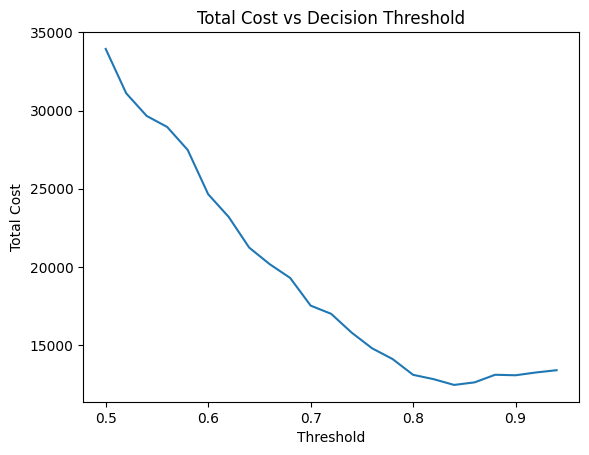

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(results_df["threshold"], results_df["total_cost"])
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.title("Total Cost vs Decision Threshold")
plt.show()


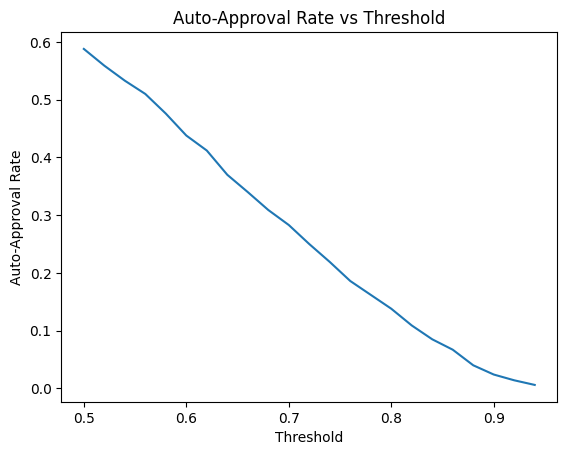

In [28]:
plt.figure()
plt.plot(results_df["threshold"], results_df["auto_approval_rate"])
plt.xlabel("Threshold")
plt.ylabel("Auto-Approval Rate")
plt.title("Auto-Approval Rate vs Threshold")
plt.show()


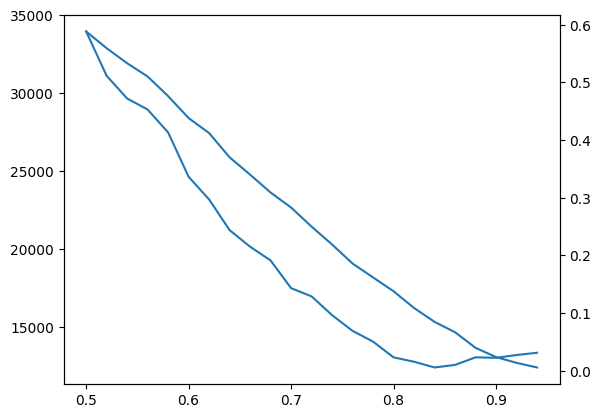

In [29]:
plt.figure()
plt.plot(results_df["threshold"], results_df["total_cost"])
plt.twinx()
plt.plot(results_df["threshold"], results_df["auto_approval_rate"])
plt.show()


In [30]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_combined, y_train)

y_prob_xgb = xgb_model.predict_proba(X_test_combined)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


XGBoost ROC-AUC: 0.6976643685959959


In [31]:
def summarize_model(y_test, y_prob, model_name="Model"):

    from sklearn.metrics import roc_auc_score
    import numpy as np

    # ROC
    roc = roc_auc_score(y_test, y_prob)

    # Threshold sweep
    thresholds = np.arange(0.5, 0.96, 0.02)
    results = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        false_positive_cost = fp * FP_COST
        false_negative_cost = fn * FN_COST
        manual_reviews = np.sum(y_prob < t)
        manual_review_cost = manual_reviews * MANUAL_REVIEW_COST

        total_cost = false_positive_cost + false_negative_cost + manual_review_cost

        results.append((t, total_cost, np.mean(y_prob >= t)))

    results_df = pd.DataFrame(results, columns=["threshold", "total_cost", "auto_rate"])

    optimal = results_df.loc[results_df["total_cost"].idxmin()]

    # Baseline (with human error)
    human_error_cost = len(y_test) * HUMAN_ERROR_RATE * FP_COST
    baseline_cost = len(y_test) * MANUAL_REVIEW_COST + human_error_cost

    print("="*60)
    print(f"{model_name} SUMMARY")
    print("="*60)
    print("ROC-AUC:", round(roc, 4))
    print("Baseline Cost:", baseline_cost)
    print("Optimal Threshold:", round(optimal["threshold"], 3))
    print("Optimal Total Cost:", round(optimal["total_cost"], 2))
    print("Cost Reduction:", round(baseline_cost - optimal["total_cost"], 2))
    print("Auto-Approval Rate:", round(optimal["auto_rate"], 3))
    print("="*60)


In [32]:
summarize_model(y_test, y_prob_text, model_name="Logistic + Text")
summarize_model(y_test, y_prob_xgb, model_name="XGBoost + Text")


Logistic + Text SUMMARY
ROC-AUC: 0.7141
Baseline Cost: 20000.0
Optimal Threshold: 0.84
Optimal Total Cost: 12440.0
Cost Reduction: 7560.0
Auto-Approval Rate: 0.085
XGBoost + Text SUMMARY
ROC-AUC: 0.6977
Baseline Cost: 20000.0
Optimal Threshold: 0.94
Optimal Total Cost: 13054.0
Cost Reduction: 6946.0
Auto-Approval Rate: 0.042
